**we need to install brian packages because it doesn't come with drive**

In [ ]:
%pip install brian2
%pip install brian2tools
%pip install scipy
!pip install --upgrade scipy
%pip install elephant

     |████████████████████████████████| 1.2MB 6.3MB/s 
  Created wheel for brian2: filename=Brian2-2.4.2-cp37-cp37m-linux_x86_64.whl size=1257121 sha256=573bceae9cd97222e1513ebb089e8a2cb6bbbcf5839777b8f3fd745d0a87ec2c
  Stored in directory: /root/.cache/pip/wheels/5d/4b/cf/ef50e71df5479d67f981cbb17b1d842381019d27ba144d57de
Successfully built brian2
     |████████████████████████████████| 71kB 4.5MB/s 
     |████████████████████████████████| 27.4MB 184kB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
     |████████████████████████████████| 2.0MB 5.0MB/s 
     |████████████████████████████████| 2.1MB 21.6MB/s 
     |████████████████████████████████| 92kB 9.5MB/s 
  Created wheel for elephant: filename=elephant-0.10.0-cp37-none-any.whl size=802397 sha256=1eefdf1fab1b1cc8b0115e18913f854ffe06ad477b26169

In [ ]:
from brian2 import *
from brian2tools import *
import numpy as np
import pandas as pd
from scipy import io
from scipy import sparse
from scipy import stats
import matplotlib.pyplot as plt
import array as arr
from google.colab import drive
drive.mount('/content/gdrive')
import sys
sys.path.append('/content/gdrive/MyDrive/Figures_Package')

Mounted at /content/gdrive


In [ ]:
#this function takes as input the first and second momentum of the weights population given in supp table 1 
#it transforms the average and var into the average and std of a lognormal distribution (formulas taken from wikipedia)

def process_params(av, av2):
    var = (av2 - av**2)
    
    mu = np.log(av**2/(av**2 + var)**(1/2))
    sigma = np.log(1 + var/av**2)
    
    return mu, sigma

In [ ]:
#the weight distribution parameters are processed and stored in non-array variables to be passed to brian
#in the future let's just do this computation and store the values in a file to read

avs = np.array([0.37, 0.66, 0.44, 0.54])
avs2 = np.array([0.26, 0.65, 0.49, 0.53])

lognormal_mu = []
lognormal_std = []

for i in range(len(avs)):
    mu, sigma = process_params(avs[i], avs2[i])
    lognormal_mu.append(mu)
    lognormal_std.append(sigma)
    
ee_mu = lognormal_mu[0]
ee_std = lognormal_std[0]
ie_mu = lognormal_mu[1]
ie_std = lognormal_std[1]
ei_mu = lognormal_mu[2]
ei_std = lognormal_std[2]
ii_mu = lognormal_mu[3]
ii_std = lognormal_std[3]

In [ ]:
initial_v = np.load('/content/gdrive/MyDrive/Figures_Package/Networks/initial_voltage.npy')

In [ ]:
w_EE = sparse.load_npz('/content/gdrive/MyDrive/Figures_Package/Structured_Weigths/w_EE_sparse.npz')
w_IE = sparse.load_npz('/content/gdrive/MyDrive/Figures_Package/Structured_Weigths/w_IE_sparse.npz')
w_EI = sparse.load_npz('/content/gdrive/MyDrive/Figures_Package/Structured_Weigths/w_EI_sparse.npz')
w_II = sparse.load_npz('/content/gdrive/MyDrive/Figures_Package/Structured_Weigths/w_II_sparse.npz')

In [ ]:
j_EE, i_EE, w_EE = sparse.find(w_EE)
j_IE, i_IE, w_IE = sparse.find(w_IE)
j_EI, i_EI, w_EI = sparse.find(w_EI)
j_II, i_II, w_II = sparse.find(w_II)

In [ ]:
patterns = pd.read_csv('/content/gdrive/MyDrive/Figures_Package/Structured_Weigths/patterns.csv',header=None)
patterns = patterns.values
pattern0 = patterns.T[0].astype(int64)
pattern1 = patterns.T[1].astype(int64)
pattern2=patterns.T[2].astype(int64)
pattern3=patterns.T[3].astype(int64)
#pattern4=patterns.T[4].astype(int64)
#pattern5=patterns.T[5].astype(int64)
#pattern6=patterns.T[6].astype(int64)

In [ ]:
#define network parameters

#total size of the network
N = 40000

#threshold, reset and refractory parameters
v_theta = 33*mV
v_reset = 24.75*mV
tau_ref = 1*ms
v_0 = -1000*mV

#indices that delimit inhibitory and excitatory populations 20/80
first_inh = 0
last_inh = int(0.2*N)
first_exc = last_inh
last_exc = N


#these are additional parameters to play with resizing of weights (in paper would be 1)
g_E = 1
g_I = 1


#External drive to each population

H_in = 57.8*mV
H_ex = 77.6*mV
#envelopes = np.array([((1.5 - 0.15*i)*pattern6 + (0.25 + 0.075*i)*ones(N) if i<10 else (ones(N))) for i in range(120)])
#stimulus = TimedArray(envelopes, dt=25*ms)
#envelopes = np.array([(1.5 - 0.15*i)*pattern6 + (0.25 + 0.075*i)*ones(N)  for i in range(11)])
#stimulus = TimedArray(envelopes, dt=50*ms)
#envelopes = np.array([(1.5 - 0.15*i)*pattern6 + (0.25 + 0.075*i)*ones(N)  for i in range(11)])
#stimulus = TimedArray(envelopes, dt=50*ms)

#envelopes1 = np.array([1.5*pattern1 + 0.25*ones(N) for i in range(10)])
#envelopes2 = np.array([1.5*pattern2 + 0.25*ones(N) for i in range(20) if i>10])
#envelopes3 = np.array([1.5*pattern3 + 0.25*ones(N) for i in range(30) if i>20])
#envelopes=[*envelopes1, *envelopes2, *envelopes3]

#envelopes = np.array([1.5*pattern6 + 0.25*ones(N) if i<11 else for in range(11)])
#stimulus = TimedArray(envelopes, dt=200*ms)

#albert tests on corrected matrices
#envelopes = np.array([(1.5 - 0.15*i)*pattern0 + (0.25 + 0.075*i)*ones(N)  for i in range(11)])
envelopes1 = np.array([((1.5 - 0.15*i)*pattern0 + (0.25 + 0.075*i)*ones(N) if i<10 else (ones(N))) for i in range(80)])
envelopes2 = np.array([((1.5 - 0.15*i)*pattern1 + (0.25 + 0.075*i)*ones(N) if i<10 else (ones(N))) for i in range(80)])
envelopes3 = np.array([((1.5 - 0.15*i)*pattern2 + (0.25 + 0.075*i)*ones(N) if i<10 else (ones(N))) for i in range(80)])
envelopes=[*envelopes1, *envelopes2, *envelopes3]
stimulus = TimedArray(envelopes, dt=25*ms)



tau_in = np.log((H_in - v_reset)/(H_in - v_theta))*second;
tau_ex = np.log((H_ex - v_reset)/(H_ex - v_theta))*second;


#clear brian scope to reset any past variables
start_scope()

#define the model that each neuron will follow
tau = 10*ms
eqs = '''
dv/dt = -(v - H_ext*stimulus(t, i))/tau : volt (unless refractory)
H_ext : volt
'''

#the original network is defined
all_neurons = NeuronGroup(N, eqs, threshold = 'v>v_theta', reset = 'v=v_reset', refractory = tau_ref, method = 'exact')

#to work with subpopulations bria-n uses slicing notation
in_neurons = all_neurons[first_inh:last_inh]
ex_neurons = all_neurons[first_exc:last_exc]

all_neurons.v = initial_v*mV

#define external drive according to supp table 1
in_neurons.H_ext = H_in
ex_neurons.H_ext = H_ex
#in_neurons.H = '(24 + 9.1*rand())*mV'
#ex_neurons.H = '(24 + 9.1*rand())*mV'


#initialize the synaptic object for the different subpopulation pairs
S_EE = Synapses(ex_neurons, ex_neurons, 'w : volt', on_pre ='v += w')
S_IE = Synapses(ex_neurons, in_neurons, 'w : volt', on_pre ='v += w')
S_EI = Synapses(in_neurons, ex_neurons,'w : volt', on_pre ='v -= w')
S_II = Synapses(in_neurons, in_neurons, 'w : volt', on_pre ='v -= w')


#connect them according to probabilities in supp table 1
S_EE.connect(i=i_EE, j=j_EE)
S_IE.connect(i=i_IE, j=j_IE)
S_EI.connect(i=i_EI, j=j_EI)
S_II.connect(i=i_II, j=j_II)



#distribute them log-normal according to parameters obtained in processing cells (beginning of notebook)
S_EE.w = w_EE*mV
S_IE.w = w_IE*mV
S_EI.w = w_EI*mV
S_II.w = w_II*mV



#define monitoring variables. these can monitor the whole population or a desired subpopulation

#monitors spiking events
M_in = SpikeMonitor(in_neurons[400:500])
M_ex = SpikeMonitor(ex_neurons[0:400])
M=SpikeMonitor(all_neurons)
M_i=SpikeMonitor(all_neurons[0:100])
M_e=SpikeMonitor(all_neurons[last_inh:last_inh+400])

#M2=SpikeMonitor(all_neurons2)
#monitors voltage with time
#V_all = StateMonitor(all_neurons, 'v', record = [1, 100, 10000, 32000])

In [ ]:
defaultclock.dt = 0.005*ms
total_time = 6000*ms

run(total_time, report = 'text')

WARNING    "i" is an internal variable of group "neurongroup", but also exists in the run namespace with the value 3. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


Starting simulation at t=0. s for a duration of 6. s
85.825 ms (1%) simulated in 10s, estimated 11m 29s remaining.
173.39 ms (2%) simulated in 20s, estimated 11m 12s remaining.
264.505 ms (4%) simulated in 30s, estimated 10m 51s remaining.
0.358805 s (5%) simulated in 40s, estimated 10m 29s remaining.
0.452805 s (7%) simulated in 50s, estimated 10m 13s remaining.
0.546395 s (9%) simulated in 1m 0s, estimated 9m 59s remaining.
0.639555 s (10%) simulated in 1m 10s, estimated 9m 47s remaining.
0.73326 s (12%) simulated in 1m 20s, estimated 9m 35s remaining.
0.825585 s (13%) simulated in 1m 30s, estimated 9m 24s remaining.
0.91606 s (15%) simulated in 1m 40s, estimated 9m 15s remaining.
1.008925 s (16%) simulated in 1m 50s, estimated 9m 4s remaining.
1.1011 s (18%) simulated in 2m 0s, estimated 8m 54s remaining.
1.19405 s (19%) simulated in 2m 10s, estimated 8m 43s remaining.
1.28638 s (21%) simulated in 2m 20s, estimated 8m 33s remaining.
1.37994 s (22%) simulated in 2m 30s, estimated 8m 

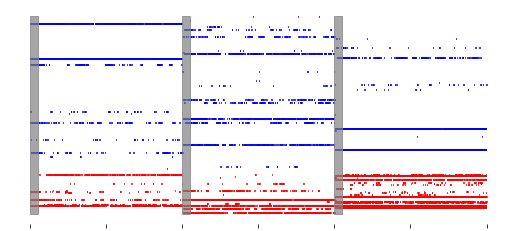

In [ ]:
import seaborn as sns
from matplotlib.patches import Rectangle 
spike_timings_in = M_in.t/second
spike_indices_in = M_in.i[:]
spike_timings_ex = M_ex.t/second
spike_indices_ex = M_ex.i[:]
plt.figure(figsize=(9, 4))
scatter(spike_timings_ex, spike_indices_ex+100 , marker = '_', color = 'b', s=1)
scatter(spike_timings_in, spike_indices_in , marker = '_', color = 'r', s=1)
rect=Rectangle((0,0),0.1,500, alpha=0.7, color='grey')
plt.gca().add_patch(rect);
rect2=Rectangle((2,0),0.1,500,alpha=0.7, color='grey' )
plt.gca().add_patch(rect2);
rect3=Rectangle((4,0),0.1,500,alpha=0.7, color='grey' )
plt.gca().add_patch(rect3);
plt.yticks([])
frame1 = plt.gca()
frame1.axes.xaxis.set_ticklabels([])
sns.despine(top=True, right=True, left=True, bottom=True)
#plt.show()
plt.savefig('/content/gdrive/MyDrive/Figures_Package/Figures/figure5A_raster.png', dpi=300)

**THIS WILL BE IT:**

In [ ]:
# Convert brian2_obj into numpy array
def export_brian2(brian_obj):

  """
  inputs:
  brian2_obj = a brian2_obj type variable

  outputs:
  spike_indices = measured values
  spike_times = times of measurements (in ms)
  """
  spike_indices = np.array(brian_obj.i)
  spike_times =  np.array(brian_obj.t) # time in ms

  return spike_indices, spike_times

In [ ]:
# Calculate firing rate for time bins
def firing_rate_b(brian2_obj,all_neurons,t0,t_end, time_window):

  """
  inputs:
  brian2_obj = a brian2_obj type variable
  all_neurons = all_neurons variable
  time_window = the size of the time window in sec
  t0 = look timepoint from t0 (in sec)
  t_end = end of the firing rate calculation (in sec)

  outputs:
  output = all the firing rate values in an array (columns=neurons, rows=time bins)
  """
  [spike_indices,spike_times] = export_brian2(brian2_obj) #convert input brian2_obj type to numpy arrays (values and times)
  """ error messages """
  if t0>t_end:
    raise Exception("The t_0 should be smaller than t_end")
  if t0> max(spike_times) or t_end > max(spike_times):
    raise Exception("Please give a number for t0 and t_end that is smaller than ",max(spike_times))
  
  """basic variables"""
  num_time_bins = int((t_end-t0)/time_window) #calculate number of time windows between start end end time
  num_neur = len(all_neurons) #give the highest number of neuron indexes ->this will give the number of rows at the output
  print(num_time_bins,num_neur)
  output = np.zeros((num_time_bins,num_neur)) #empty matrix variable
  #T = time_window/1000 #time window size in sec
  start = t0 #start time in sec

  """calculations"""
  for idt in range(0,num_time_bins): #iterate through all the time window
    inp_t = [] #variable for time points at the time window examined
    inp_n = []   #variable for neuron activities at the time window examined
    neur_bin = [] #variable for neuron activities at the neuron examined

    inp_t = np.where(np.logical_and(spike_times>=start, spike_times<=start+time_window)) #get time point's indexes at the time window examined
    inp_n = spike_indices[inp_t] #get neurons at the time window examined
    for idn in np.unique(inp_n): #iterate through neurons
      neur_bin.append(np.where(inp_n==idn)) #get the number of activities of a single neuron in the time window
      if len(neur_bin)==0: #if there are no activities the firing rate is 0
        output[idt][idn] = 0
      else:
        output[idt][idn] = len(neur_bin)/(time_window*1000) #calculate firing rate
        #print(len(neur_bin)/(time_window*1000))
      neur_bin = []
    start = start+time_window
   

  return output


In [ ]:
#import sys
fir1=firing_rate_b(M,all_neurons,0.01,5.999974,0.01)
#np.set_printoptions(threshold=sys.maxsize) #this print the full matrix threshold=sys.maxsize
#[spike_indices,spike_times] = export_brian2(M)
#print(fir1)
len(fir1[0])

598 40000


40000

In [ ]:
def correlation(fir1,pattern):
  patt=pattern[0:40000]
  patt=patt/np.linalg.norm(pattern)
  corr=np.empty([598,1])
  #print(corr)
  for binid in range(len(fir1)):
    firneurons=fir1[binid]
    firneurons=firneurons/np.linalg.norm(firneurons)
    dot=numpy.dot(firneurons, patt)
    #print(dot)
    corr[binid]=dot
  return corr

In [ ]:
corr=correlation(fir1,pattern0)
corr2=correlation(fir1,pattern1)
corr3=correlation(fir1,pattern2)
#corr2=correlation(fir1,pattern4)

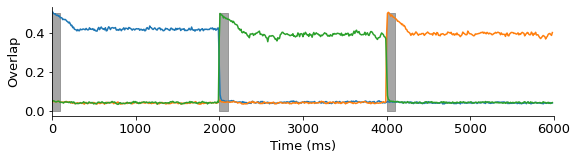

In [ ]:
time=numpy.linspace(1, 598, num=598)
plt.figure(figsize=(9, 2))
plt.plot(10*time,corr)
plt.plot(10*time,corr3)
plt.plot(10*time,corr2)
k=[0,100]
v=[0.5,0.5]

k4=[2000,2100]
v4=[0.5,0.5]
k5=[4000,4100]
v5=[0.5,0.5]

plt.fill_between(k,v, alpha=0.7, color='grey')
plt.fill_between(k4,v4, alpha=0.7, color='grey')
plt.fill_between(k5,v5, alpha=0.7, color='grey')
plt.yticks(fontsize=13)
plt.xticks(fontsize=13)
plt.xlim(0,6000)
plt.ylabel("Overlap",fontsize=13)
xlabel("Time (ms)",fontsize=13)
sns.despine(top=True, right=True, left=False, bottom=False)
#plt.show()
plt.savefig('/content/gdrive/MyDrive/Figures_Package/Figures/figure5A_overlap.png', dpi=300, bbox_inches = 'tight')
